In [1]:
# Install Kaggle API
!pip install kaggle


In [2]:
# Upload Kaggle API token
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [3]:
# Move the uploaded Kaggle API token to the appropriate location and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
# Download the dataset from Kaggle
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia


Dataset URL: https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia
License(s): unknown
 99% 2.04G/2.06G [00:17<00:00, 88.1MB/s]
100% 2.06G/2.06G [00:17<00:00, 123MB/s] 


In [5]:
# Unzip the downloaded dataset
import zipfile
with zipfile.ZipFile('/content/chest-xray-covid19-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import VGG16  # Example: Using VGG16 model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [28]:
# Define the hyperparameters
batch_size = 32
num_classes = 3  # Update to the number of classes
num_epochs = 5
learning_rate = 0.001
image_size = (224, 224)


In [29]:
# Define the class names and labels
class_names = ['PNEUMONIA', 'COVID19', 'NORMAL']
class_labels = {name: i for i, name in enumerate(class_names)}

# Define the data paths
data_dir = '/content/dataset/Data/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')


In [30]:
# Create image data generators for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create image data iterators for loading and batching the images
train_iterator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=True,
    seed=42
)

test_iterator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_names,
    shuffle=False
)

Found 5044 images belonging to 3 classes.
Found 1388 images belonging to 3 classes.


In [31]:
# Create a base model using a different CNN model with pre-trained weights
base_model = VGG16(
    include_top=False,
    weights='imagenet',  # You can specify 'imagenet' or None for random initialization
    input_shape=(image_size[0], image_size[1], 3),
    pooling='avg'
)

# Freeze the base model layers
base_model.trainable = False

# Create a custom model by adding a ResNet layer on top of the base model
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))
x = base_model(inputs, training=False)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

# Compile the model with loss, optimizer, and metrics
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)


In [32]:
# Print the model summary
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 14716227 (56.14 MB)
Trainable params: 1539 (6.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [33]:
# Train the model with the train data
history = model.fit(
    train_iterator,
    epochs=num_epochs,
    validation_data=test_iterator,  # Use test_iterator for validation
)


Epoch 1/5
158/158 [==============================] - 132s 828ms/step - loss: 0.6738 - accuracy: 0.7847 - val_loss: 0.3159 - val_accuracy: 0.8797
Epoch 2/5
158/158 [==============================] - 152s 965ms/step - loss: 0.2611 - accuracy: 0.9044 - val_loss: 0.2485 - val_accuracy: 0.9099
Epoch 3/5
158/158 [==============================] - 132s 831ms/step - loss: 0.2052 - accuracy: 0.9231 - val_loss: 0.1934 - val_accuracy: 0.9272
Epoch 4/5
158/158 [==============================] - 127s 806ms/step - loss: 0.1705 - accuracy: 0.9407 - val_loss: 0.3114 - val_accuracy: 0.8991
Epoch 5/5
158/158 [==============================] - 127s 807ms/step - loss: 0.1714 - accuracy: 0.9308 - val_loss: 0.1910 - val_accuracy: 0.9294


In [34]:
# Save the model
model.save('/content/image_prediction_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
# Evaluate the model on the test data
evaluation_result = model.evaluate(test_iterator)

# Display overall accuracy
print(f"Overall Accuracy on Test Data: {evaluation_result[1] * 100:.2f}%")


44/44 [==============================] - 19s 424ms/step - loss: 0.1910 - accuracy: 0.9294
Overall Accuracy on Test Data: 92.94%


In [36]:
# Predict probabilities for test data
y_pred_prob = model.predict(test_iterator)

# Get predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = test_iterator.classes

# Print unique classes inferred from y_true
unique_classes = np.unique(y_true)
print("Unique classes:", unique_classes)

# Define the class names and labels
class_names = ['PNEUMONIA', 'COVID19', 'NORMAL']

# Generate classification report with all class names
report = classification_report(y_true, y_pred, target_names=class_names)

print("Classification Report:")
print(report)


44/44 [==============================] - 18s 420ms/step
Unique classes: [0 1 2]
Classification Report:
              precision    recall  f1-score   support

   PNEUMONIA       0.97      0.92      0.95       855
     COVID19       1.00      0.94      0.97       216
      NORMAL       0.81      0.94      0.87       317

    accuracy                           0.93      1388
   macro avg       0.92      0.93      0.93      1388
weighted avg       0.94      0.93      0.93      1388



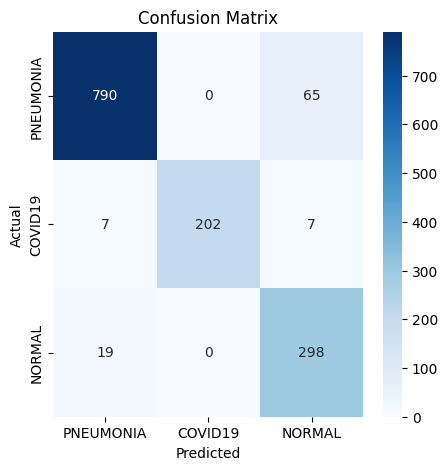

In [40]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

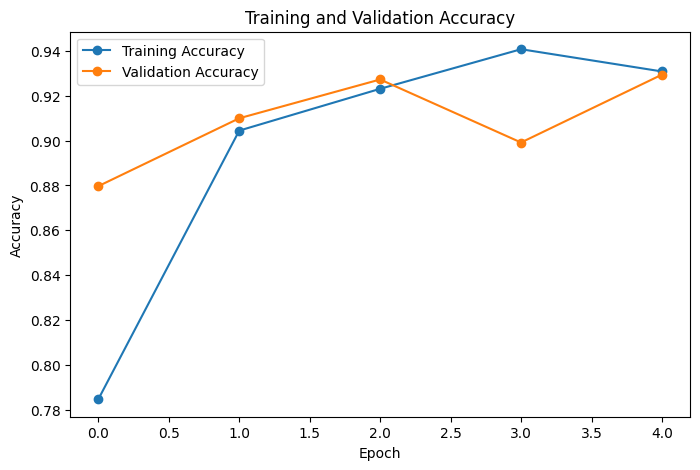

In [37]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 5))

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='-', marker='o')

# Plot validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='-', marker='o')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show plot
plt.show()


Saving COVID_7.png to COVID_7.png
1/1 [==============================] - 1s 1s/step


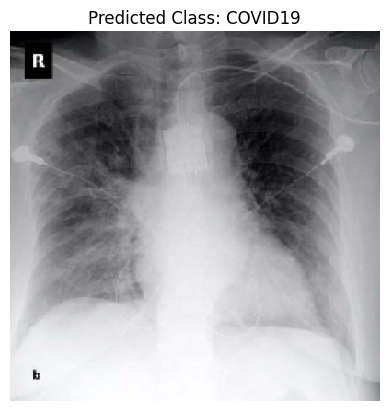

In [38]:

# Upload a file from your local machine
uploaded = files.upload()

for filename in uploaded.keys():
    # Load and preprocess the selected image
    img_path = '/content/' + filename
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array[np.newaxis, ...])
    # Make predictions
    predictions = model.predict(img_array)
    # Get the predicted class label
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    # Display the selected image and predicted class
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()